<h1>Capstone EDA and Image Augmentation</h1>

This notebook contains exploratory data analysis, steps taken to clean the dataset, and augment existing images for new image creation. 

In [5]:
import numpy as np
import albumentations as A
import cv2
from PIL import Image, ImageShow
import shutil
import os
import re
from matplotlib import pyplot as plt
import random
import pandas as pd
import seaborn as sns
%matplotlib inline

The following code was used to train/test split images

In [6]:
stuff_source = "./rev/"
img_source = "./holsters/images/"
annot_source = "./holsters/labels/"
img_destination = "./test/images"
annot_destination = "./test/labels/"

img_files = os.listdir(img_source)
# i = 1
# for file in img_files:
#     if i % 6 == 0:
#         new_img_path = shutil.move(f"{img_source}/{file}", img_destination)
#     i+=1

annot_files = os.listdir(annot_source)
# j = 1
# for file in annot_files:
#     if j % 6 == 0:
#         new_annot_path = shutil.move(f"{annot_source}/{file}", annot_destination)
#     j+=1

<h2>Data Preview and cleaning</h2>

All images are sized (416, 416, 3)<br>
<br>
Total images: 3622 images, from original dataset and google image search<br><br>
Dataset composition:
961 images predominately featuring holstered weapons<br>
583 images predominately featuring revolvers<br>
2078 images predominately featuring semi-automatic handguns<br>
Other classes or multiple instances of each class are seen in images within these subsections.<br><br>

Many images from the original dataset were dropped for some of the following reasons: 
Removed because the guns depicted were not handguns: 26<br>
Removed for other reasons: 384<br>
<br>
Other reasons include:<br>
•	Image depicts a cartoon weapon<br>
•	Image is from a video game<br>
•	Watermark too prominent<br>
•	Poor image quality<br>
•	Barely visible<br>
•	Technical drawing<br>
•	Wood or toy gun<br>
<br>
Those removed because of not being a handgun were either a long gun or not a gun at all (ie paint spray gun)
<br><br>
With the creation of this final dataset that divides handguns into two groups (revolvers and semi-automatic pistols) as well as the addition of the holstered handgun class, many more images were dropped for quality concerns. Blurry image quality was suspected to be a cause for early modeling shortcomings and was addressed in this final dataset.<br><br>

In [7]:
#Below function reads annotation files and returns bounding box annotations as a list
def read_file(file):
    list = []
    with open(file, 'rt') as fd:
        read = fd.read()
        stuff = read.split()
        stuff = [float(i) for i in stuff]
        n = 5
        for i in range(0, int((len(stuff)/5))):
            list.append(stuff[n-4:n])
            n += 5
    return list

In [8]:
#for use if I ever decide I need padding on images
def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

#Source: https://note.nkmk.me/en/python-pillow-add-margin-expand-canvas/

Use the below function to turn images into new, augmented images

In [17]:
def augment_gun_images(picture_total, source):
    path, dirs, files = next(os.walk(f'{source}/images'))
    file_count = len(files)
    if file_count <= picture_total:
        try:
            #set sett to train or test
            img_source = f'{source}/images'
            annot_source = f'{source}/labels'
            img_files = os.listdir(img_source)
            annot_files = os.listdir(annot_source)

            train_labels_list = []

            keys=[i for i in img_files] 
            values= [read_file(f'{source}/labels/{i}') for i in annot_files]
            dictionary = dict(zip(keys, values)) 
            dkeys = [i for i in dictionary.keys()]

            #Here is where the meat of it is:
            for i in range(0,picture_total):
                path, dirs, files = next(os.walk(f'{source}/images'))
                file_count = len(files)
                file_name = f'aug_img{file_count+1}'
                image_name = random.choice(dkeys) #starts with a random image from the image pool
                pillow_image = Image.open(f"{source}/images/{image_name}")
                image = np.array(pillow_image)
                #If I decide on padding:
            #         pillow_image = Image.open(f"{source}/{sett}/images/{image_name}")
            #         im_new = add_margin(pillow_image, 2, 2, 2, 2, 0)
            #         image = np.array(im_new)

                label_name = image_name.replace('jpg', 'txt')
                bboxes = [i for i in dictionary[image_name]]
                cat_list = []
                with open(f'{source}/labels/{label_name}', 'rt') as fd:
                    read = fd.read()
                    stuff = read.split()
                    stuff = [float(i) for i in stuff]
                count=0
                for i in range(0, int((len(stuff)/5))):
                    cat_list.append(int(stuff[count]))
                    count += 5
                count=0
                for i in bboxes:
                    if cat_list[count] == 0:
                        i.append('handgun')
                    elif cat_list[count] == 1:
                        i.append('holstered')
                    count+=1
                count=0

                bboxes_nocat = [i[0:4] for i in dictionary[image_name]]

                class_labels = ['handgun', 'holstered']
                category_ids = [0, 1]
                category_id_to_name = {0:'handgun', 1:'holstered'}


                transform = A.Compose([
                    A.RandomBrightnessContrast(always_apply=False, p=0.6, brightness_limit=(-0.2, 0.1), 
                             contrast_limit=(-0.2, 0.2), brightness_by_max=True),
                    A.VerticalFlip(always_apply=False, p=0.1),
                    A.HorizontalFlip(always_apply=False, p=0.4),
                    A.HueSaturationValue(always_apply=False, p=0.2, hue_shift_limit=(-20, 20), 
                            sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
                    A.InvertImg(always_apply=False, p=0.05),
                    A.MotionBlur(always_apply=False, p=0.15, blur_limit=(3, 12)),
                    A.RGBShift(always_apply=False, p=0.2, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), 
                               b_shift_limit=(-20, 20)),
                    A.Rotate(always_apply=False, p=0.1, limit=(-360, 360), interpolation=1, border_mode=0, 
                             value=(0, 0, 0), mask_value=None),
                    A.Rotate(always_apply=False, p=0.4, limit=(-50, 50), interpolation=1, border_mode=0, 
                             value=(0, 0, 0), mask_value=None),
                    A.Rotate(always_apply=False, p=0.8, limit=(-20, 20), interpolation=1, border_mode=0, 
                             value=(0, 0, 0), mask_value=None),
                    A.ToGray(always_apply=False, p=0.2),
                ],
                bbox_params = A.BboxParams(
                  format='yolo',
                  min_visibility=0.5))


            #     # np.random.seed(42) 
                transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
                transformed_image = transformed['image']
                transformed_bboxes = transformed['bboxes']
                transformed_class_labels = transformed['class_labels']
                transformed_bboxes_nocat = [i[0:4] for i in transformed_bboxes]
                tb_lol = []
                for i in transformed_bboxes_nocat:
                    tb_lol.append([j for j in i])
                if len(tb_lol) < 1:
                    pass
                else:
                    listy_thing = list(zip(tb_lol, cat_list))


                    file = open(f"{source}/labels/{file_name}.txt", "a+") 
                    for i in listy_thing:
                        file.write(str(i[1]) + " " + str(i[0][0]) + ' ' + str(i[0][1]) + ' ' + str(i[0][2]) + ' ' + str(i[0][3]))
                        file.write('\n')
                    file.close() 
                    im = Image.fromarray(np.uint8(transformed_image))
                    im.save(f'{source}/images/{file_name}.jpg')
        except:
            augment_gun_images(picture_total, source)
    else:
        print(f'{picture_total} number of photos in {source}')

In [11]:
def augment_holster_images(picture_total, source):
    path, dirs, files = next(os.walk(f'{source}/images'))
    file_count = len(files)
    if file_count <= picture_total:
        try:
            #set sett to train or test
            img_source = f'{source}/images'
            annot_source = f'{source}/labels'
            img_files = os.listdir(img_source)
            annot_files = os.listdir(annot_source)

            train_labels_list = []

            keys=[i for i in img_files] 
            values= [read_file(f'{source}/labels/{i}') for i in annot_files]
            dictionary = dict(zip(keys, values)) 
            dkeys = [i for i in dictionary.keys()]

            #Here is where the meat of it is:
            for i in range(0,picture_total):
                path, dirs, files = next(os.walk(f'{source}/images'))
                file_count = len(files)
                file_name = f'holster_aug_img{file_count+1}'
                image_name = random.choice(dkeys) #starts with a random image from the image pool
                pillow_image = Image.open(f"{source}/images/{image_name}")
                image = np.array(pillow_image)
                #If I decide on padding:
            #         pillow_image = Image.open(f"{source}/{sett}/images/{image_name}")
            #         im_new = add_margin(pillow_image, 2, 2, 2, 2, 0)
            #         image = np.array(im_new)

                label_name = image_name.replace('jpg', 'txt')
                bboxes = [i for i in dictionary[image_name]]
                cat_list = []
                with open(f'{source}/labels/{label_name}', 'rt') as fd:
                    read = fd.read()
                    stuff = read.split()
                    stuff = [float(i) for i in stuff]
                count=0
                for i in range(0, int((len(stuff)/5))):
                    cat_list.append(int(stuff[count]))
                    count += 5
                count=0
                for i in bboxes:
                    if cat_list[count] == 0:
                        i.append('handgun')
                    elif cat_list[count] == 1:
                        i.append('holstered')
                    count+=1
                count=0

                bboxes_nocat = [i[0:4] for i in dictionary[image_name]]

                class_labels = ['handgun', 'holstered']
                category_ids = [0, 1]
                category_id_to_name = {0:'handgun', 1:'holstered'}


                transform = A.Compose([
                    A.RandomBrightnessContrast(always_apply=False, p=0.6, brightness_limit=(-0.2, 0.1), 
                                             contrast_limit=(-0.2, 0.2), brightness_by_max=True),
                    A.HorizontalFlip(always_apply=False, p=0.5),
                    A.HueSaturationValue(always_apply=False, p=0.2, hue_shift_limit=(-20, 20), 
                            sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
                    A.InvertImg(always_apply=False, p=0.05),
                    A.MotionBlur(always_apply=False, p=0.15, blur_limit=(3, 12)),
                    A.RGBShift(always_apply=False, p=0.2, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), 
                               b_shift_limit=(-20, 20)),
                    A.Rotate(always_apply=False, p=0.1, limit=(-90, 90), interpolation=1, border_mode=0, 
                             value=(0, 0, 0), mask_value=None),
                    A.Rotate(always_apply=False, p=0.2, limit=(-25, 25), interpolation=1, border_mode=0, 
                             value=(0, 0, 0), mask_value=None),
                    A.Rotate(always_apply=False, p=0.9, limit=(-15, 15), interpolation=1, border_mode=0, 
                             value=(0, 0, 0), mask_value=None),
                    A.ToGray(always_apply=False, p=0.2),
                ],
                bbox_params = A.BboxParams(
                  format='yolo',
                  min_visibility=0.5))

            #     # np.random.seed(42) 
                transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
                transformed_image = transformed['image']
                transformed_bboxes = transformed['bboxes']
                transformed_class_labels = transformed['class_labels']
                transformed_bboxes_nocat = [i[0:4] for i in transformed_bboxes]
                tb_lol = []
                for i in transformed_bboxes_nocat:
                    tb_lol.append([j for j in i])
                if len(tb_lol) < 1:
                    pass
                else:
                    listy_thing = list(zip(tb_lol, cat_list))


                    file = open(f"{source}/labels/{file_name}.txt", "a+") 
                    for i in listy_thing:
                        file.write(str(i[1]) + " " + str(i[0][0]) + ' ' + str(i[0][1]) + ' ' + str(i[0][2]) + ' ' + str(i[0][3]))
                        file.write('\n')
                    file.close() 
                    im = Image.fromarray(np.uint8(transformed_image))
                    im.save(f'{source}/images/{file_name}.jpg')
        except:
            augment_holster_images(picture_total, source)
    else:
        print(f'{picture_total} number of photos in {source}')

In [12]:
#The following code takes a yolo bounding box in list format and converts it to coordinates of [x_min, y_min, width, height]
#to display bounding boxes and their labels within a notebook. Albumentations seems to want coco format.

def convert_box(yolo_bb):
    list_of_lists = []
    for i in yolo_bb:
        width = i[2]*416
        height = i[3]*416
        x_min = (i[0]*416)-((width)/2)
        x_max = (i[0]*416)+((width)/2)
        y_min = (i[1]*416)-((height)/2)
        y_max = (i[1]*416)+((height)/2)
        list_of_lists.append([x_min, y_min, width, height])
    return list_of_lists

In [13]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)
    
#Source: albumentations library documentation

In [19]:
augment_gun_images(picture_total=5000, source='.')

5000 number of photos in .


In [50]:
pillow_image = Image.open(f"./holsters/images/holster_aug_img860.jpg")
image = np.array(pillow_image)
bboxes = read_file('./holsters/labels/holster_aug_img860.txt')
bboxes_nocat = [i[0:4] for i in bboxes]

In [51]:
bboxes

[[0.4580201465605193,
  0.5376726201729716,
  0.33179017770941166,
  0.3800297006099906]]

<h3>Example photo with bounding box</h3>

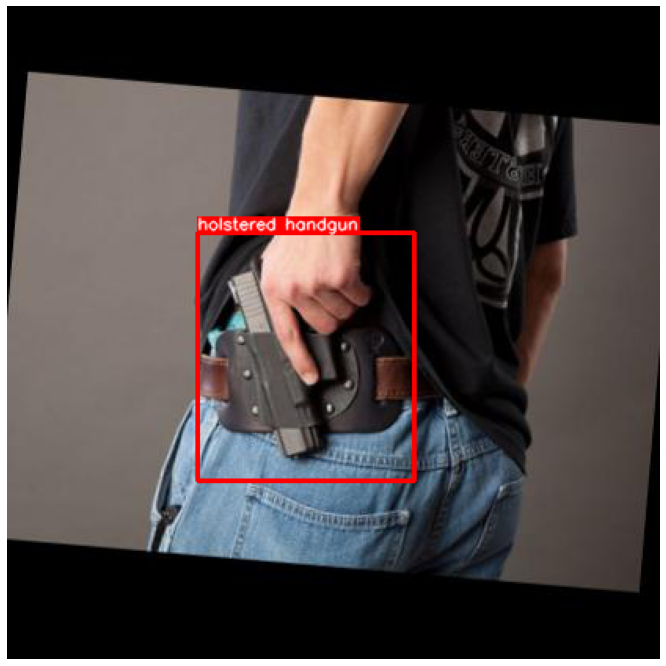

In [52]:
visualize(image, bboxes=convert_box(bboxes_nocat), category_ids = [2], category_id_to_name = {0:'SA handgun', 1:'revolver', 2:'holstered handgun'})

In [11]:
keys=[i for i in img_files] 
values= [read_file(f'{stuff_source}/labels/{i}') for i in annot_files]
dictionary = dict(zip(keys, values)) 
dkeys = [i for i in dictionary.keys()]

In [12]:
dictionary

{'sa_img1.jpg': [[0.4254807692307692,
   0.2439903846153846,
   0.22115384615384615,
   0.28125]],
 'sa_img10.jpg': [[0.5036057692307693,
   0.48197115384615385,
   0.9242788461538461,
   0.8401442307692307]],
 'sa_img100.jpg': [[0.6646634615384616,
   0.6646634615384616,
   0.11778846153846154,
   0.31490384615384615]],
 'sa_img1000.jpg': [[0.613027, 0.436782, 0.09834, 0.061303]],
 'sa_img1001.jpg': [[0.173691, 0.512133, 0.052363, 0.03576]],
 'sa_img1002.jpg': [[0.408046, 0.44636, 0.0894, 0.047254]],
 'sa_img1003.jpg': [[0.372286, 0.510217, 0.671775, 0.61175]],
 'sa_img1004.jpg': [[0.596424, 0.36143, 0.0447, 0.028097]],
 'sa_img1005.jpg': [[0.503831, 0.507024, 0.906769, 0.592593]],
 'sa_img1006.jpg': [[0.227969, 0.661558, 0.283525, 0.201788],
  [0.482759, 0.627075, 0.243934, 0.189017],
  [0.768199, 0.584291, 0.316731, 0.226054],
  [0.53129, 0.458493, 0.243934, 0.206897],
  [0.287356, 0.487867, 0.277139, 0.186462],
  [0.335249, 0.329502, 0.268199, 0.158365],
  [0.644955, 0.332056, 0.35

Distribution of bounding box number in images in training set

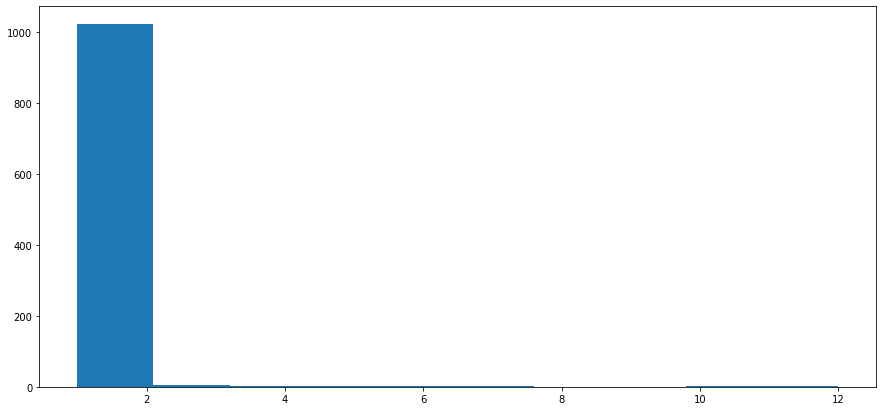

In [32]:
num_bboxes = []
for i in dictionary.values():
    num_bboxes.append(len(i))

fig = plt.figure(figsize=(15,7))
ax = plt.gca()
ax.hist(num_bboxes)
plt.show()

<h3>Example of augmented images</h3>

In [492]:
pillow_image1 = Image.open(f"./yolov5/data5/")
image1 = np.array(pillow_image1)
plt.figure(figsize=(20, 25))
plt.imshow(image1, interpolation='nearest')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './images/aug_imgs.jpg'

In [503]:
pillow_image2 = Image.open(f"./yolov5/cleaned_data/train/images/handgun_img2356.jpg")
bbox2 = read_file('./yolov5/cleaned_data/train/labels/handgun_img2356.txt')
image2 = np.array(pillow_image2)

pillow_image3 = Image.open(f"./yolov5/cleaned_data/train/images/handgun_img1343.jpg")
bbox3 = read_file('./yolov5/cleaned_data/train/labels/handgun_img1343.txt')
image3 = np.array(pillow_image3)

pillow_image4 = Image.open(f"./yolov5/cleaned_data/train/images/handgun_img1378.jpg")
bbox4 = read_file('./yolov5/cleaned_data/train/labels/handgun_img1378.txt')
image4 = np.array(pillow_image4)

FileNotFoundError: [Errno 2] No such file or directory: './yolov5/cleaned_data/train/images/handgun_img2356.jpg'

In [ ]:
bbox3

In [ ]:
visualize(image3, bboxes=convert_box(bbox3), category_ids = [0], category_id_to_name = {0:'handgun'})

In [ ]:
visualize(image2, bboxes=convert_box(bbox2), category_ids = [0], category_id_to_name = {0:'handgun'})

In [ ]:
visualize(image4, bboxes=convert_box(bbox4), category_ids = [0], category_id_to_name = {0:'handgun'})